In [1]:
# imports here!

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal
import cmath
PI = np.pi                                  #### IMPORTANT : initialising PI as np.pi
exp = np.e                                  #### IMPORTANT : initialising exp as np.e

### Koidala Surya Prakash
### EE18BTECH11026

# Q1 : Motion Estimation

In [2]:
class image:                                             ## class for an image .. provides histogram, thresholding
    def __init__(self,path = None,img = None,plot = False,title = None):
        if(path!=None):
            self.img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        else :
            self.img = img
        self.h,self.w = np.shape(self.img)
        
        if(plot == 1):
            plt.title(title)
            plt.imshow(self.img,cmap = 'gray')
            plt.plot()
            plt.figure()

### Setup

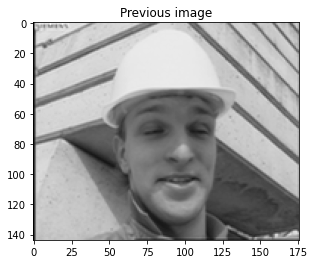

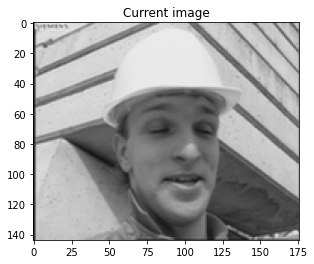

<Figure size 432x288 with 0 Axes>

In [3]:
img1 = image(path = 'first_frame.png',plot = True,title = 'Previous image')
Prev = img1.img   ### P --> Previous
img2 = image(path = 'second_frame.png',plot = True,title = 'Current image')
Curr = img2.img   ### C --> current

In [4]:
### Code


######################################
####    Code for 1.1
######################################


### This transforms the image into macro block pieces.
### i.e;  144*176 ---> 9*11*256   256 is a vector containing the elments of the macroblock 
def create_MB_matrix(I,size):  ### Size = size of block = 16
    M,N = I.shape
    m,n = int(M/size), int(N/size)
    MB = np.zeros((m,n,size**2))
    temp = np.zeros((size,size))
    for i in range(m):
        for j in range(n):
            temp = I[i*size:(i+1)*size,j*size:(j+1)*size]
            
            T = temp.reshape((size*size,))
            MB[i][j] = T
    return MB


def MAD(v1,v2):         ### This function resuts the mad of indices of the MB_matrix. i.e return  sum(|v1 - v2|)
    v = np.mean(abs(v1-v2))  ### Returns the mean absolute difference of both 256 vectors
    return v

### Checks if the block to be searhed exists fully .. To avoid boundary cases
def valid(Prev,index_pair,size):
    i,j = index_pair
    if(i-7 >-1 and i+8 < Prev.shape[0] and j-7 >-1 and j+8 < Prev.shape[1] ):
        return True
    return False


### Extracts the elements in a window whose center is the index_pair
def extract_block(Prev,index_pair,size):
    ic,jc = int(index_pair[0]),int(index_pair[1])
    Blk = np.zeros((size,size))
    Blk = Prev[ic-7:ic+9 , jc-7:jc+9]
    
    return Blk
    
## This is for searching over a neighbourhood with a given step value
## A max of 9 blocks are searched
def mini_search(v,Prev,index_pair,s,size):   ### v --> block  s-->step
    i,j = index_pair
    steps = np.array([[i,j],[i+s,j+s],[i-s,j+s],[i+s,j-s],[i-s,j-s],[i+s,j],[i-s,j],[i,j+s],[i,j-s]])
    mini = 10000
    for k in steps:
        if(valid(Prev,k,size)):
            temp = extract_block(Prev,k,size)
            t_v = temp.reshape((size*size,))
            
            diff = MAD(v,t_v)
            if(diff < mini):
                mini  = diff
                ans = k
    return ans
    
    
def search(v,Prev,ic,jc,size):  ### 3stage search
    index = np.array([ic,jc])
    s1 = mini_search(v,Prev,index,4,size)  ## Stage :01
    s2 = mini_search(v,Prev,s1,2,size)     ## Stage :02
    s3 = mini_search(v,Prev,s2,1,size)     ## Stage :03
    return s3
    
def create_MV(Prev,MB,size):  ### Creates the motion vector of the form (9*11*2))
    M,N = Prev.shape        
    m,n = int(M/size), int(N/size)
    MV = np.zeros((m,n,2))
    MV_rel = np.zeros((m,n,2))
    
    for i in range(m):
        for j in range(n):
            ic = i*size + 7
            jc = j*size + 7   ### Pixel indices of center of the block
            
            MV[i][j] = search(MB[i][j],Prev,ic,jc,size) 
            MV_rel[i][j] = search(MB[i][j],Prev,ic,jc,size)  - np.array([ic,jc])
    return MV,MV_rel
    
    
######################################
####    Code for 1.2
######################################  

### This plots the Motion vector on the current image 
    
def plot_MV(Curr,MV,size,title):
    plt.imshow(Curr,cmap = 'gray')
    m,n,_ = MV.shape
    for i in range(m):
        for j in range(n):
            plt.arrow(j*size + (size*0.5),
                      i*size + (size*0.5),
                      MV[i][j][1],
                      MV[i][j][0],
                      head_width = 2,
                      width = 0.3,
                      color = 'r',)
            #plt.annotate("", xy=(0.5, 0.5), xytext=(0, 0), arrowprops=dict(arrowstyle="fancy")

    plt.title(title)        
    plt.show()
    plt.figure()
    
    
######################################
####    Code for 1.3
######################################
    

#### Create Predicted image of Curr using MV and Prev
def create_MCPF(Prev,MV,size):
    Curr_cap = np.zeros(Prev.shape)
    m,n,_ = MV.shape
    
    for i in range(m):
        for j in range(n):
            Curr_cap[i*size:(i+1)*size, j*size:(j+1)*size] = extract_block(Prev,MV[i][j],size)
    return Curr_cap



### 1.1 Generating a Motion Vector(MV) 

### Implementation 1.1

In [5]:
MB_curr = create_MB_matrix(Curr,16)
MV_abs,MV_rel = create_MV(Prev,MB_curr,16)
print(MV_abs.shape)
print("--------------This is the relative motion vector !!--------------")
print(MV_rel)

(9, 11, 2)
--------------This is the relative motion vector !!--------------
[[[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0. -1.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [-5. -5.]
  [ 4. -2.]
  [ 0. -1.]
  [ 0.  0.]
  [ 0.  0.]
  [-2. -2.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 1.  1.]
  [ 1. -4.]
  [ 1. -1.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 1. -3.]
  [ 1. -5.]
  [ 1. -4.]
  [ 1. -2.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0. -1.]
  [ 1. -3.]
  [ 1. -4.]
  [ 1. -4.]
  [ 0. -2.]
  [ 0.  0.]
  [ 2.  2.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 1.  1.]
  [ 1.  0.]
  [ 1. -3.]
  [ 1. -4.]
  [ 1. -5.]
  [ 1. -2.]
  [ 1.  1.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 1.  0.]
  [ 1. -1.]
  [ 0. -4.]
  [ 0. -4.]
  [ 1. -2.]
  [ 0.  0.]
  [ 0.  0.]

### Implementation 1.2

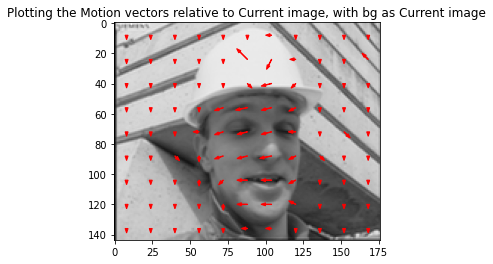

<Figure size 432x288 with 0 Axes>

In [6]:
### Plotting the MV : 
plot_MV(Curr,MV_rel,16,title = "Plotting the Motion vectors relative to Current image, with bg as Current image")

### Impletation 1.3  
#### Genereating the Motion compensated Predicted frame from the first image and MV matrix.

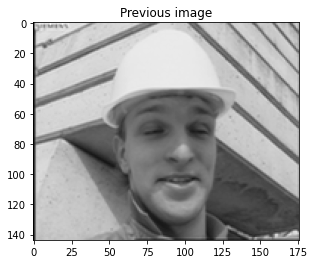

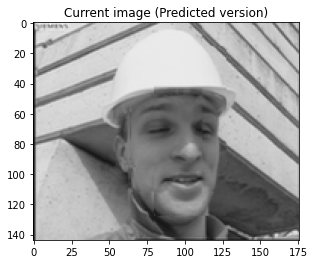

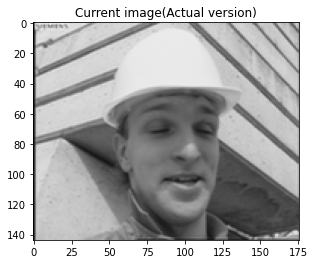

<Figure size 432x288 with 0 Axes>

In [7]:
C_c = create_MCPF(Prev,MV_abs,16)
image(img = Prev,plot = True,title = "Previous image")
image(img = C_c,plot = True,title = "Current image (Predicted version)")
image(img = Curr,plot = True, title = "Current image(Actual version)")


### 1.4 Computing and Visualising the error

The mean absolute error value b/w the predicted and actual image is 2.96 


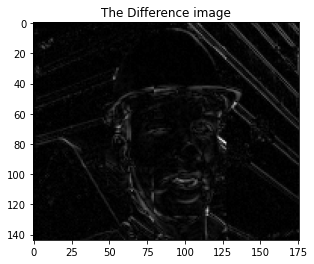

<Figure size 432x288 with 0 Axes>

In [8]:
Difference_img = abs(Curr - C_c)
v1 = Curr.reshape((Curr.shape[0]*Curr.shape[1],))
v2 = C_c.reshape((C_c.shape[0]*C_c.shape[1],))
error = MAD(v1,v2)

print('The mean absolute error value b/w the predicted and actual image is %.2f '%error)

image(img = Difference_img,plot = True, title = "The Difference image")


# Q2 : SSIM index

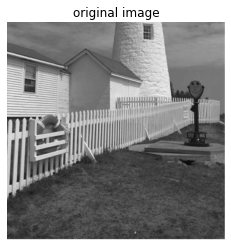

In [9]:
class image :
    
    def disp_img(self, I, title = None): # A utility func for displaying images 
        plt.imshow(I, cmap = 'gray')
        plt.axis('off')
        plt.title(title)
        plt.show()
    
    ##### -------------------- Common code for Both 2 & 3 reading and displaying images ---#
    def __init__ (self, path, display = False):
        self.path = path
        self.I = cv2.imread(self.path, cv2.IMREAD_GRAYSCALE) ## Reading the contents of the image I 
        if(display): ## Displaying I
            self.disp_img(self.I)
            
    #def add gaussian 
    # def add compression
    # def blurring
    
    
img = image('lighthouse.png')
I2 = image('lighthouse.png')


img.disp_img(img.I, title = 'original image')

In [10]:
class conv_oper:
    def __init__(self):
        pass

    
    def zero_padding(self, I, target_shape):
        J = np.zeros(target_shape)
        ### padding zeros at the bottom right 
        J[0:I.shape[0],0:I.shape[1]] = I[0:I.shape[0],0:I.shape[1]]
        return J
    #### Question 1.b --> Matrix approach 
    ##########################################################################################
    def find_DFT(self, I): ### funct to compute DFT using matrix approach
        
        self.J = I.copy()
        N = self.J.shape[0]
        self.DFT = np.zeros((N,N), dtype = complex)
        
        phase =  -1*(2*PI)/N
        w = cmath.rect(1,phase)
        W = np.array([[ w**(i*j) for j in range(N)]for i in range(N)] ,dtype = complex) # Complex exponential matrix

        self.DFT = W@self.J@W
        return self.DFT
    
    
    def find_IDFT(self, I): ### finding IDFT using matrix approach
        self.J = I
        N = self.J.shape[0]
        self.IDFT = np.zeros((N,N), dtype = complex)
        
        phase =  -1*(2*PI)/N
        w = cmath.rect(1,phase)
        W = np.array([[ w**(i*j) for j in range(N)]for i in range(N)] ,dtype = complex) # Complex exponential matrix

        W_inv = (1/N) * np.conjugate(W)
        
        self.IDFT = W_inv@self.J@W_inv
        self.IDFT = np.round(abs(self.IDFT))
        self.IDFT = np.array(self.IDFT)
        
        return self.IDFT
    
    ### Padded and computing IDFT( DFT(I). DFT(F))
    def linear_conv_with_DFT(self, I, F):
        N,M = I.shape
        P,P  = F.shape
        
        #### Padding both images..
        I = self.zero_padding(I,(N+P-1,M+P-1))
        F = self.zero_padding(F,(N+P-1,M+P-1))
        
        I_DFT = self.find_DFT(I)
        F_DFT = self.find_DFT(F)
        
        J = np.multiply(I_DFT, F_DFT, dtype= complex)
        
        J_IDFT = self.find_IDFT(J)
        J_cropped = J_IDFT[0:N,0:N]
        
        return J_IDFT, J_cropped

In [11]:
class quality_mertics(image):
    def __init__(self):
        pass
    
    def gaussian_kernel(self,F, sig = 1):
        # returns a gaussian kern for convolution of size (F,F)
        x = np.linspace(-(F-1)/2., (F-1)/2., F)
        gauss_1d = np.exp(-0.5*np.square(x) / (np.square(sig))) # 1D kernel
        kernel = np.outer(gauss_1d, gauss_1d)  # using seperability
        kernel = kernel/np.sum(kernel)
        return kernel
    
    def circular_conv(self,I,F):
        J = np.zeros((I.shape))
        M,N = J.shape
        
        for i in range(M):
            for j in range(N):
                temp = 0
                for p in range(F.shape[0]):
                    for q in range(F.shape[1]):
                        temp+= I[(i-p)%M][ (j-q)%N ] * F[p][q]
                J[i][j] = np.round(temp)
        return J
    
    def SSIM(self,I,J, display = True):
        
        I = I.astype(np.float64) ## since the one entering is a np.unit8 matrix
        J = J.astype(np.float64)

        ### Constants
        self.W = self.gaussian_kernel(F = 11) ## A gaussian filter of size 11
        self.C1,self.C2 = (0.02*255)**2, (0.03*255)**2
        self.C3 = self.C2/2.
        

        
        mu_I = conv_oper().linear_conv_with_DFT( I,self.W)[1]
        mu_J = conv_oper().linear_conv_with_DFT( J,self.W)[1]
        
        #print(mu_I)
        I_sq, mu_I_sq = (I**2) , (mu_I)**2
        J_sq, mu_J_sq = (J**2) , (mu_J)**2


        sig_I_sq = np.abs(conv_oper().linear_conv_with_DFT(I_sq, self.W)[1] - mu_I_sq)
        sig_J_sq = np.abs(conv_oper().linear_conv_with_DFT(J_sq, self.W)[1] - mu_J_sq)
        
        sig_I = sig_I_sq**0.5
        sig_J = sig_J_sq**0.5

        
        sig_IJ = np.abs(conv_oper().linear_conv_with_DFT(I*J, self.W)[1] - (mu_I)*(mu_J))
        
        self.L = ((2*mu_I*mu_J) + self.C1 )/(mu_I_sq + mu_J_sq + self.C1)

        
        self.C = ((2*sig_I*sig_J) + self.C2)/(sig_I_sq + sig_J_sq + self.C2)
        
        self.S = (sig_IJ + self.C3)/((sig_I*sig_J) + self.C3)
        
        self.SSIM = self.L * self.C * self.S
        self.mean_SSIM = np.mean(self.SSIM)
        
        if(display):
            self.disp_img(self.SSIM, title = 'SSIM = {}'.format(self.mean_SSIM))
        
        
        

### 2a) Adding AWGN to the image

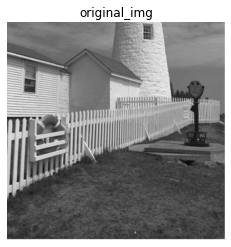

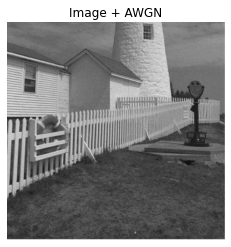

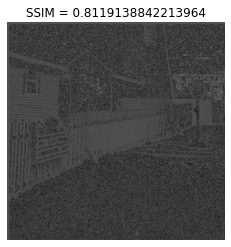

In [12]:
def noise(I, mean, var):
    sig = var**0.5
    return np.random.normal(mean,sig,I.shape)

I = img.I

AWGN_noise = noise(I,0,50)
J = I+AWGN_noise

P2 = quality_mertics()
P2.disp_img(I,'original_img')
P2.disp_img(J,'Image + AWGN')
P2.SSIM(I= I,J = J)


### gaussian blurred image

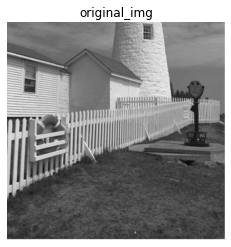

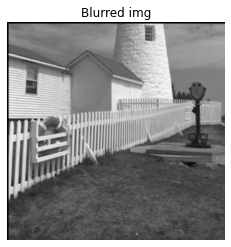

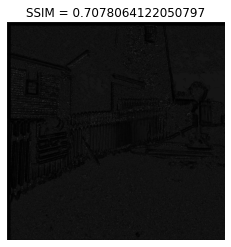

In [13]:
I = img.I
F = quality_mertics().gaussian_kernel(F = 11)
_,J = conv_oper().linear_conv_with_DFT(I, F)

P2 = quality_mertics()
P2.disp_img(I,'original_img')
P2.disp_img(J,'Blurred img')
P2.SSIM(I= I,J = J)

### Jpeg compressed image

In [14]:
### for jpeg compression

from io import StringIO
from PIL import Image
im_png = Image.open('lighthouse.png')
im_png = im_png.convert('RGB')
buffer = StringIO()
im_png.save('jpeg_quality_90.jpg', "JPEG", quality=90)
im_png.save('jpeg_quality_10.jpg', "JPEG", quality=10)
im_png.save('jpeg_quality_1.jpg', "JPEG", quality=1)

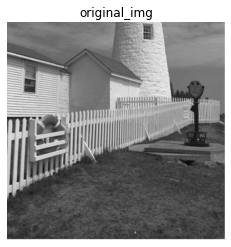

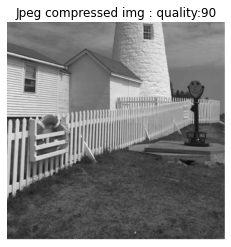

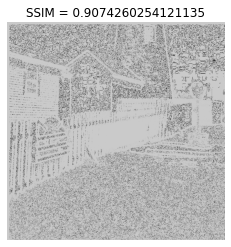

In [15]:
img1 = image('lighthouse.png')
img2 = image('jpeg_quality_90.jpg')

I = img1.I
J = img2.I


P2 = quality_mertics()
P2.disp_img(I,'original_img')
P2.disp_img(J,'Jpeg compressed img : quality:90')
P2.SSIM(I= I,J = J)

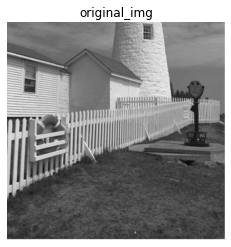

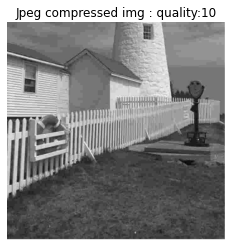

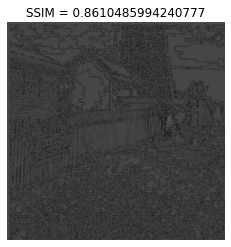

In [16]:
img1 = image('lighthouse.png')
img2 = image('jpeg_quality_10.jpg')

I = img1.I
J = img2.I


P2 = quality_mertics()
P2.disp_img(I,'original_img')
P2.disp_img(J,'Jpeg compressed img : quality:10')
P2.SSIM(I= I,J = J)

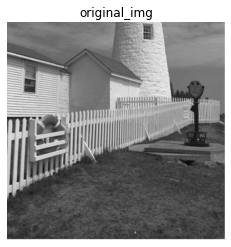

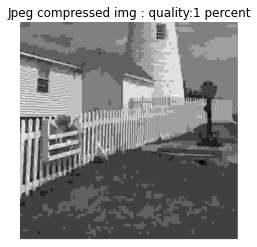

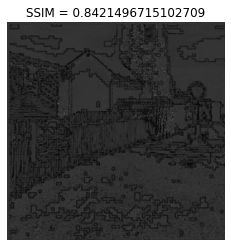

In [17]:
img1 = image('lighthouse.png')
img2 = image('jpeg_quality_1.jpg')

I = img1.I
J = img2.I


P2 = quality_mertics()
P2.disp_img(I,'original_img')
P2.disp_img(J,'Jpeg compressed img : quality:1 percent')
P2.SSIM(I= I,J = J)

# Q3 : Edge detection

In [18]:
class kernels(object):
    
    def __init__(self):
        pass
    
    def centered_2d_diff(self):
        x_filter = np.array([[-0.5,0,0.5]])
        y_filter= x_filter.T
        
        return x_filter,y_filter
    
    def roberts_oper(self):
        x_filter = np.array([[-1 ,0],[0, 1]])
        y_filter = np.array([[0 ,-1],[1, 0]])
        
        return x_filter, y_filter
    
    def prewitt_oper(self):
        x_filter = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
        y_filter = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
        
        return x_filter/3., y_filter/3.
    
    def sobel_oper(self):
        x_filter = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
        y_filter = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
        
        return x_filter/4.,y_filter/4. 
    
    def laplacian(self):
        _filter =  np.array([[0,1,0],[1,-4,1],[0,1,0]])
        return _filter


In [19]:
class estimates(object):
    def __init__(self,Mx,My):
        self.Mx = Mx
        self.My = My
        
    def root_square(self):
        return ( (self.Mx)**2 + (self.My)**2 )**0.5
    
    def sum_of_absolutes(self):
        return (np.abs(self.Mx) + np.abs(self.My))
    
    def max_of_absolutes(self):
        return np.maximum(np.abs(self.Mx), np.abs(self.My))
        

<class 'numpy.ndarray'>


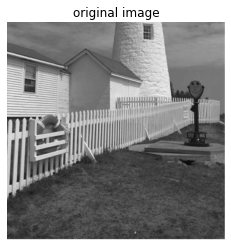

In [20]:
class image :

    def disp_img(self, I, title = None): # A utility func for displaying images 
        plt.imshow(I, cmap = 'gray')
        plt.axis('off')
        plt.title(title)
        plt.show()

    ##### -------------------- Common code for Both 2 & 3 reading and displaying images ---#
    def __init__ (self, path, display = False):
        self.path = path
        self.I = cv2.imread(self.path, cv2.IMREAD_GRAYSCALE) ## Reading the contents of the image I 
        if(display): ## Displaying I
            self.disp_img(self.I)
            
    def threshold(self,M, thresh, display=False, title =None):
        M[M>= thresh] = 255
        M[M< thresh] = 0

        if(display):
            self.disp_img(M,title)

img = image('lighthouse.png')
#I = img.I.astype(np.float64)
I = img.I
print(type(I))

img.disp_img(I, title = 'original image')

In [21]:


class conv_oper:
    def __init__(self):
        pass

    
    def zero_padding(self, I, target_shape):
        J = np.zeros(target_shape)
        ### padding zeros at the bottom right 
        J[0:I.shape[0],0:I.shape[1]] = I[0:I.shape[0],0:I.shape[1]]
        return J
    #### Question 1.b --> Matrix approach 
    ##########################################################################################
    def find_DFT(self, I): ### funct to compute DFT using matrix approach
        
        self.J = I.copy()
        N = self.J.shape[0]
        self.DFT = np.zeros((N,N), dtype = complex)
        
        phase =  -1*(2*PI)/N
        w = cmath.rect(1,phase)
        W = np.array([[ w**(i*j) for j in range(N)]for i in range(N)] ,dtype = complex) # Complex exponential matrix

        self.DFT = W@self.J@W
        return self.DFT
    
    
    def find_IDFT(self, I): ### finding IDFT using matrix approach
        self.J = I
        N = self.J.shape[0]
        self.IDFT = np.zeros((N,N), dtype = complex)
        
        phase =  -1*(2*PI)/N
        w = cmath.rect(1,phase)
        W = np.array([[ w**(i*j) for j in range(N)]for i in range(N)] ,dtype = complex) # Complex exponential matrix

        W_inv = (1/N) * np.conjugate(W)
        
        self.IDFT = W_inv@self.J@W_inv
        self.IDFT = np.round(np.real(self.IDFT))
        self.IDFT = np.array(self.IDFT)
        
        return self.IDFT
    
    ### Padded and computing IDFT( DFT(I). DFT(F))
    def linear_conv_with_DFT(self, I, F):
        N,M = I.shape

        P,P  = F.shape
        
        #### Padding both images..
        I = self.zero_padding(I,(N+P-1,M+P-1))
        F = self.zero_padding(F,(N+P-1,M+P-1))
        
        I_DFT = self.find_DFT(I)
        F_DFT = self.find_DFT(F)
        
        J = np.multiply(I_DFT, F_DFT, dtype= complex)
        
        J_IDFT = self.find_IDFT(J)
        J_cropped = J_IDFT[0:N,0:N]
        
        return J_IDFT, J_cropped

### Using "centered 2d Differencing" kernel with different estimations

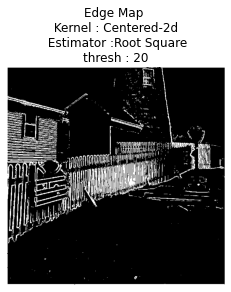

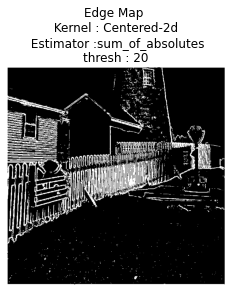

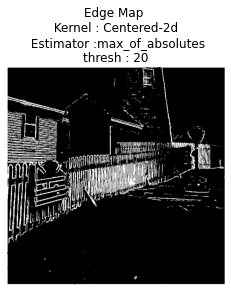

In [22]:
Fx,Fy = kernels().centered_2d_diff()


_,Mx = conv_oper().linear_conv_with_DFT(I,Fx)
_,My = conv_oper().linear_conv_with_DFT(I,Fy)


## a)
M1 = estimates(Mx,My).root_square()
title = 'Edge Map \n Kernel : Centered-2d \n Estimator :Root Square\n'
img.threshold(M1, thresh=20, display=True, title = title + str('thresh : {}'.format(20)))


## b)
M2 = estimates(Mx,My).sum_of_absolutes()
title = 'Edge Map \n Kernel : Centered-2d \n Estimator :sum_of_absolutes\n'
img.threshold(M2, thresh=20, display=True, title = title + str('thresh : {}'.format(20)))

## c)
M3 = estimates(Mx,My).max_of_absolutes()
title = 'Edge Map \n Kernel : Centered-2d \n Estimator :max_of_absolutes\n'
img.threshold(M3, thresh=20, display=True, title = title + str('thresh : {}'.format(20)))



### Using "Roberts" kernel with different estimations

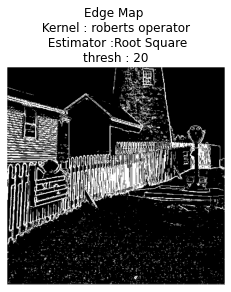

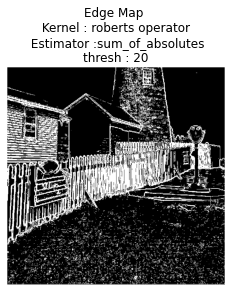

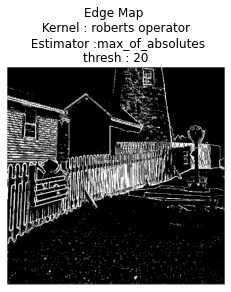

In [23]:
Fx,Fy = kernels().roberts_oper()


_,Mx = conv_oper().linear_conv_with_DFT(I,Fx)
_,My = conv_oper().linear_conv_with_DFT(I,Fy)


## a)
M1 = estimates(Mx,My).root_square()
title = 'Edge Map \n Kernel : roberts operator \n Estimator :Root Square\n'
img.threshold(M1, thresh=20, display=True, title = title + str('thresh : {}'.format(20)))


## b)
M2 = estimates(Mx,My).sum_of_absolutes()
title = 'Edge Map \n Kernel : roberts operator \n Estimator :sum_of_absolutes\n'
img.threshold(M2, thresh=20, display=True, title = title + str('thresh : {}'.format(20)))

## c)
M3 = estimates(Mx,My).max_of_absolutes()
title = 'Edge Map \n Kernel : roberts operator \n Estimator :max_of_absolutes\n'
img.threshold(M3, thresh=20, display=True, title = title + str('thresh : {}'.format(20)))



### Using "Prewitt" kernel with different estimations

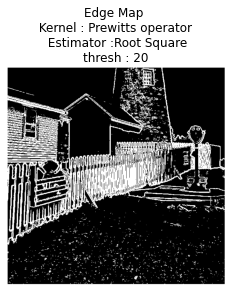

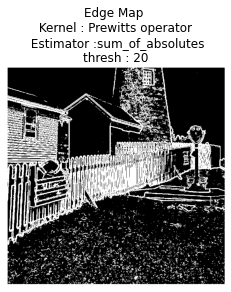

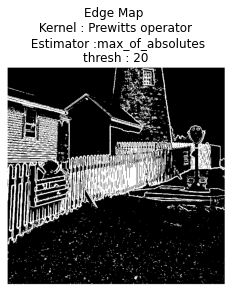

In [24]:
Fx,Fy = kernels().prewitt_oper()


_,Mx = conv_oper().linear_conv_with_DFT(I,Fx)
_,My = conv_oper().linear_conv_with_DFT(I,Fy)


## a)
M1 = estimates(Mx,My).root_square()
title = 'Edge Map \n Kernel : Prewitts operator \n Estimator :Root Square\n'
img.threshold(M1, thresh=20, display=True, title = title + str('thresh : {}'.format(20)))


## b)
M2 = estimates(Mx,My).sum_of_absolutes()
title = 'Edge Map \n Kernel : Prewitts operator \n Estimator :sum_of_absolutes\n'
img.threshold(M2, thresh=20, display=True, title = title + str('thresh : {}'.format(20)))

## c)
M3 = estimates(Mx,My).max_of_absolutes()
title = 'Edge Map \n Kernel : Prewitts operator \n Estimator :max_of_absolutes\n'
img.threshold(M3, thresh=20, display=True, title = title + str('thresh : {}'.format(20)))



### Using "Sobel" kernel with different estimations

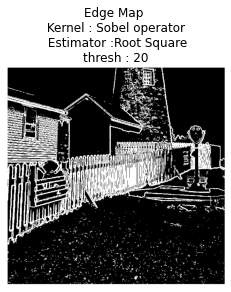

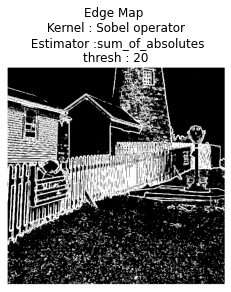

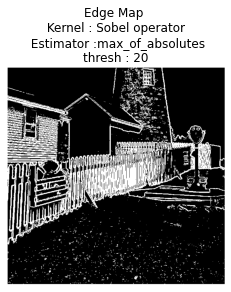

In [25]:
Fx,Fy = kernels().sobel_oper()


_,Mx = conv_oper().linear_conv_with_DFT(I,Fx)
_,My = conv_oper().linear_conv_with_DFT(I,Fy)


## a)
M1 = estimates(Mx,My).root_square()
title = 'Edge Map \n Kernel : Sobel operator \n Estimator :Root Square\n'
img.threshold(M1, thresh=20, display=True, title = title + str('thresh : {}'.format(20)))


## b)
M2 = estimates(Mx,My).sum_of_absolutes()
title = 'Edge Map \n Kernel : Sobel operator \n Estimator :sum_of_absolutes\n'
img.threshold(M2, thresh=20, display=True, title = title + str('thresh : {}'.format(20)))

## c)
M3 = estimates(Mx,My).max_of_absolutes()
title = 'Edge Map \n Kernel : Sobel operator \n Estimator :max_of_absolutes\n'
img.threshold(M3, thresh=20, display=True, title = title + str('thresh : {}'.format(20)))



## Prob: 3.2 : Using the laplacian Edge detector

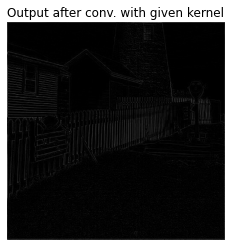

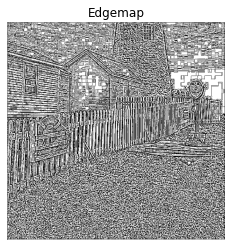

In [26]:
I = img.I.astype(np.float64)
#I = img.I
F = kernels().laplacian() ## Using laplacian kernel
_,M = conv_oper().linear_conv_with_DFT(I,F)
M = np.clip(M,0,255)

img.disp_img(M,'Output after conv. with given kernel')

edgemap = np.zeros(M.shape)
edgemap[M==0] = 1

img.disp_img(edgemap,'Edgemap')


### Prob. 3.3 LoG

denoising followed by edge detection

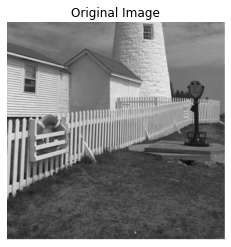

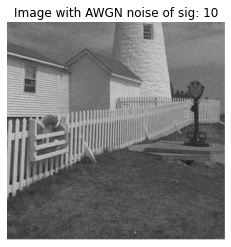

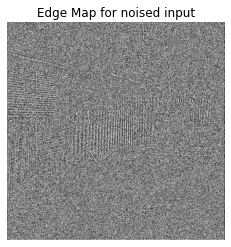

In [27]:
def noise(I, mean, var):
    sig = var**0.5
    return np.random.normal(mean,sig,I.shape)

I = img.I.astype(np.float64)
img.disp_img(I,'Original Image')
AWGN_noise = noise(I,0,225)
I_noise = I+AWGN_noise

img.disp_img(I_noise,'Image with AWGN noise of sig: 10')

F = kernels().laplacian() ## Using laplacian kernel
_,M = conv_oper().linear_conv_with_DFT(I_noise,F)
M = np.clip(M,0,255)
edgemap = np.zeros(M.shape)
edgemap[M==0] = 255

img.disp_img(edgemap,'Edge Map for noised input')

In [28]:
### Adding denoising through Gaussian pre-filter and edge detection
def prefilter(sig,N=5):
    F = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            F[i][j] = np.exp(-1*(i**2 + j**2)/(2*sig**2))
            
    F = np.array(F)
    return F



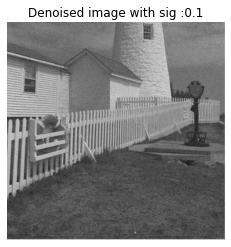

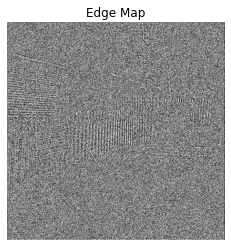

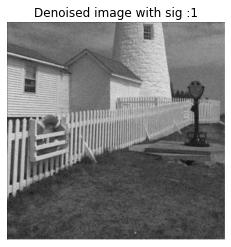

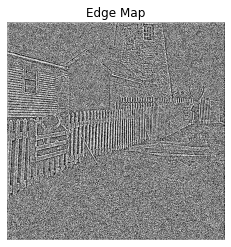

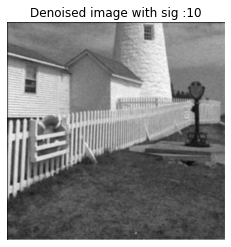

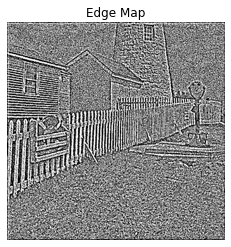

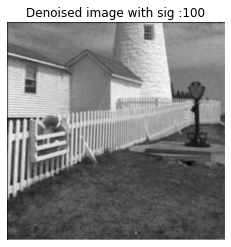

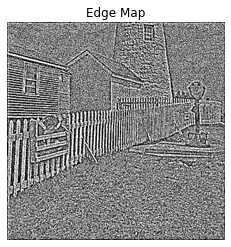

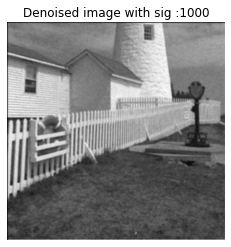

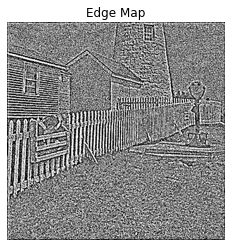

In [29]:
for i in range(-1,4):
    
    sig = 10**i
    _,I_denoise = conv_oper().linear_conv_with_DFT(I_noise,prefilter(sig))
    I_denoise = I_denoise.astype(np.float64)
    img.disp_img(I_denoise,'Denoised image with sig :{}'.format(sig))
    F = kernels().laplacian() ## Using laplacian kernel
    _,M = conv_oper().linear_conv_with_DFT(I_denoise,F)
    M = np.clip(M,0,255)
    edgemap = np.zeros(M.shape)
    edgemap[M==0] = 255

    img.disp_img(edgemap,'Edge Map')
    
    

### Inference:

# THE END